In [101]:
import numpy as np
from skimage.feature import peak_local_max
from skimage.exposure import rescale_intensity
import fitstools
from matplotlib.colors import LinearSegmentedColormap
import balltracking.mballtrack as mblt
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import readsav
import matplotlib.colors as colors
from skimage.morphology import watershed
from skimage.segmentation import find_boundaries
from scipy import ndimage as ndi

In [40]:
def read_vi(file, data_str):
    idl_dict = readsav(file)
    vi = idl_dict[data_str]
    return vi

def make_data_borders_rgb(data, borders, in_range):

    bkg_gray = rescale_intensity(np.tile(data[..., np.newaxis], (1, 1, 3)), in_range=in_range,
                                 out_range=np.uint8).astype(np.uint8)

    borders_rgb = bkg_gray.copy()
    # Color positive borders as red
    borders_rgb[borders == 1, 0] = 255
    borders_rgb[borders == 1, 1] = 0
    borders_rgb[borders == 1, 2] = 0
    # Color negative borders as cyan (accounting for color blindness)
    borders_rgb[borders == -1, 0] = 175
    borders_rgb[borders == -1, 1] = 238
    borders_rgb[borders == -1, 2] = 238

    return borders_rgb


# colormap
colors = plt.cm.Set1_r(np.linspace(0, 1, 9))
#colors = plt.cm.Paired(np.linspace(0, 1, 12))
cmap = matplotlib.colors.ListedColormap(colors, name='mycmap', N=local_maxi_coords.shape[0])

In [24]:
datafile = '/Users/rattie/Data/Don/dons_193_image.sav'
idl_dict = readsav(datafile)
print(idl_dict.keys())
data = idl_dict['s193']
print(data.shape)

dict_keys(['s193'])
(382, 377)


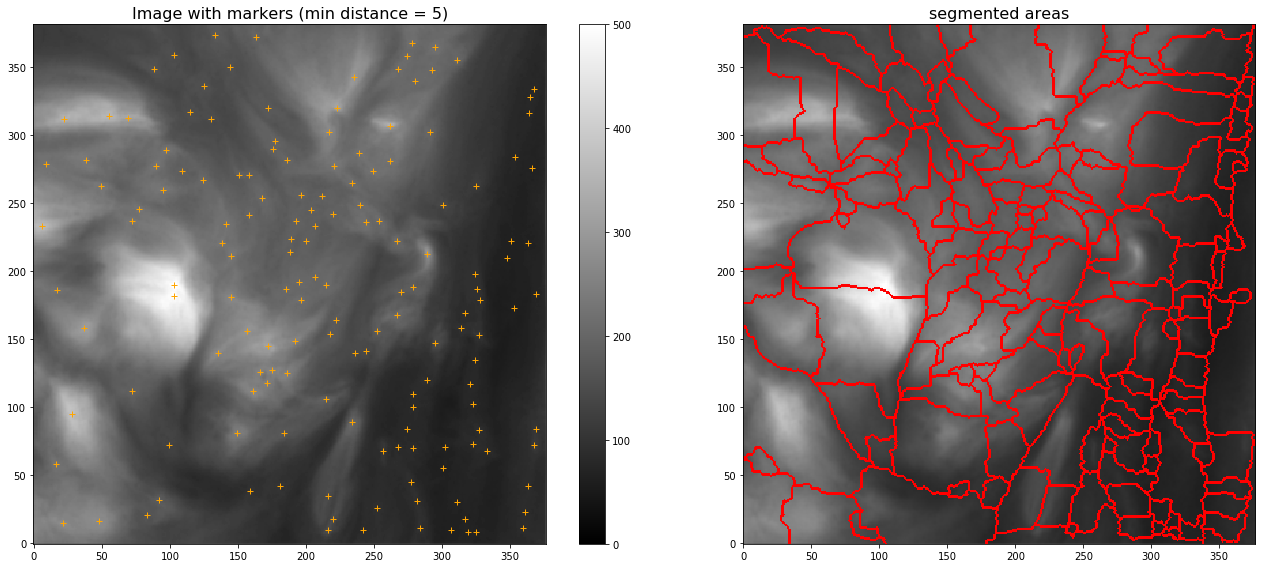

In [107]:
mind = 5


# Get coordinates of the local maxima, then invert the image with min = 0
locmax0 = peak_local_max(data, indices=True, min_distance=mind)
# x, y = locmax0[:,1], locmax0[:,0]
#markers = mblt.label_from_pos(x, y, data.shape)

locmax = peak_local_max(data, indices=False, min_distance=mind)
markers = ndi.label(locmax)[0]

wdata = data.max() - data
labels = watershed(wdata, markers)
# Get the outer boundaries
borders = find_boundaries(labels)
data_borders_rgb = make_data_borders_rgb(data, borders, (0, 500))



fs = 16
%matplotlib inline
plt.figure(figsize=(19,8))
plt.subplot(1,2,1)
# plt.imshow(data, origin='lower', cmap='gray', norm=colors.LogNorm(vmin=data.min(), vmax=data.max()))
plt.imshow(data, origin='lower', cmap='gray', vmin=0, vmax=500)
plt.plot(locmax0[:,1], locmax0[:,0], ls='none', marker='+', color='orange')
plt.colorbar()
plt.title('Image with markers (min distance = {:d})'.format(mind), fontsize=fs)


plt.subplot(1,2,2)
#plt.imshow(borders.astype(np.uint8), vmin=0, vmax=1, origin='lower', cmap='gray')
plt.imshow(data_borders_rgb, origin='lower', interpolation='nearest')
plt.title('segmented areas', fontsize=fs)
plt.tight_layout()
plt.savefig('/Users/rattie/Data/Don/segmentation_marker_watershed_mind_{:d}.png'.format(mind))

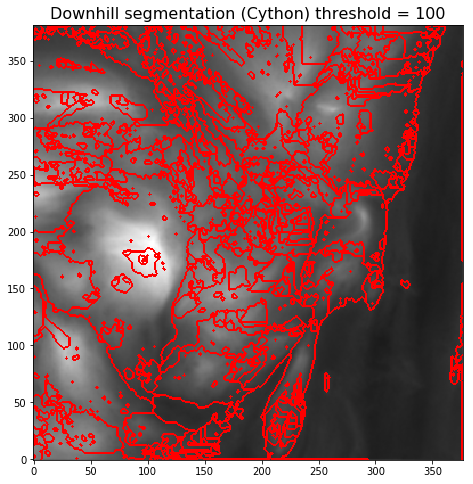

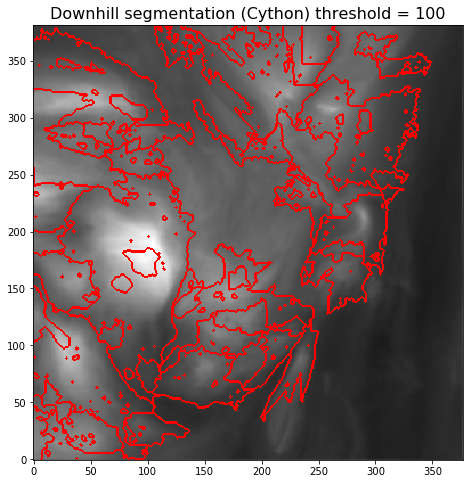

In [100]:
from image_processing import segmentation
import skimage
# Sort the the array intensity from max to min  and label each pixel with the same number if their connected (i.e do connected component labelling)
threshold = 100.0
labels2 = segmentation.detect_polarity(data.astype(np.float64), threshold)
labels2_curated = skimage.morphology.remove_small_objects(labels2.copy(), min_size=800)
labels3 = skimage.measure.label(labels2_curated, neighbors=8, background=0)
# Get the outer boundaries
borders2 = find_boundaries(labels2)
borders3 = find_boundaries(labels3)
data_borders_rgb2 = make_data_borders_rgb(data, borders2, (0, 500))
data_borders_rgb3 = make_data_borders_rgb(data, borders3, (0, 500))

plt.figure(figsize=(8,8))
plt.imshow(data_borders_rgb2, origin='lower', interpolation='nearest')
plt.title('Downhill segmentation (Cython) threshold = {:1.0f}'.format(threshold), fontsize=fs)
plt.savefig('/Users/rattie/Data/Don/downhill_segmentation_threshold_{:1.0f}.png'.format(threshold))

plt.figure(figsize=(8,8))
plt.imshow(data_borders_rgb3, origin='lower', interpolation='nearest')
plt.title('Downhill segmentation (Cython) threshold = {:1.0f}'.format(threshold), fontsize=fs)
plt.savefig('/Users/rattie/Data/Don/downhill_segmentation_threshold_{:1.0f}_relabelled.png'.format(threshold))